In [42]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

from sympy import latex
from IPython.display import display_latex

def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

from IPython.display import display_latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

import logging
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

We consider the following nonlinear ODE

$$
\ddot{x} = x - x^3 - \delta\dot{x},
$$

In first order form, the vector field reads

In [43]:
RHS = sy.Matrix([xdot, x-x**3 - delta*xdot])
disp('\\frac{d}{dt}\\begin{pmatrix}x_1 \\\ x_2 \\end{pmatrix}=',RHS)

Its Jacobian at the fixed point is

In [44]:
J = RHS.jacobian([x, xdot]).subs([(x, 1), (xdot, 0)])
disp('J=', J)

which has eigenvalues

In [45]:
eigenvals = J.eigenvals(multiple = True)
for e in eigenvals:
    disp('\\lambda = ', e)

In [46]:
deltaa = 0.1

For damping $\delta = 0.1$, we have

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

### Create data

In [47]:
def vectorfield(t,x):
    return np.array([x[1], x[0]-x[0]**3 - deltaa*x[1]])

In [48]:
t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]

In [49]:
# Initial conditions
ic_0 = np.array([0.1, 0])
ic_1 = np.array([0.32, .1])

In [50]:
# Numerical solutions
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)

In [51]:
sol_0

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1088
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])
 t_events: None
        y: array([[ 0.1       ,  0.10049375,  0.10197237, ...,  1.00308666,
         1.00270884,  1.00228073],
       [ 0.        ,  0.0098666 ,  0.01973154, ..., -0.00349872,
        -0.00404386, -0.0045026 ]])
 y_events: None

In [52]:
sol_0.y

array([[ 0.1       ,  0.10049375,  0.10197237, ...,  1.00308666,
         1.00270884,  1.00228073],
       [ 0.        ,  0.0098666 ,  0.01973154, ..., -0.00349872,
        -0.00404386, -0.0045026 ]])

In [53]:
sol_0.y[:,0]

array([0.1, 0. ])

In [54]:
sol_1.y[:,0]

array([0.32, 0.1 ])

In [55]:
# Reshape solutions into array "trajectories"
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
# Array containing time spawn
times = [t, t]

### Plot data

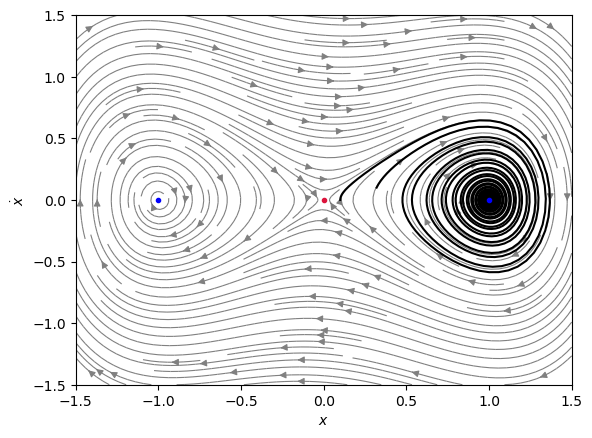

In [56]:
xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')

### Fit using SSMLearn

In [57]:
# Order
polyDeg = 3
# Degrees of freedom
ndofs = 1

In [58]:
X, y  = shift_or_differentiate(trajectories, times, 'flow') 

In [59]:
# The _ array contains the trajectories
X == trajectories

True

In [60]:
# The y array contains d./dt of the trajectories
y

[array([[ 7.06455714e-07,  9.86927452e-03,  1.97164112e-02, ...,
         -3.49853274e-03, -4.04247954e-03, -4.50259638e-03],
        [ 9.89950368e-02,  9.84877748e-02,  9.89584445e-02, ...,
         -5.85173087e-03, -5.03172241e-03, -4.12681381e-03]]),
 array([[0.10011481, 0.12790994, 0.15628938, ..., 0.00052015, 0.00115935,
         0.00176132],
        [0.27751627, 0.28208957, 0.28823439, ..., 0.00650445, 0.00627641,
         0.00591703]])]

In [61]:
# A priori knowledge
# Add the constraints to the fixed points explicitly
constLHS = [[-1, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Such that model.prediction(LHS) = RHS

In [62]:
# Fit a ridge regression model to the data
mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg, constraints = cons)

In [63]:
# Check that the constraints are enforced
print(mdl.predict(constLHS), constRHS)

[[ 3.68798958e-14 -2.30948594e-12]] [[0, 0]]


In [64]:
# Get an estimate of the linear part
linearPart = mdl.map_info['coefficients'][:,:2]

In [65]:
"""Minimize
    ||d\dt (y + f_normalform(y)) - \Lambda*(y+f_normalform(y)) - N_normalform(y+f_normalform)||^2
    where \Lambda is the linear part of the dynamics and N_normalform is the nonlinear part of the normal form dynamics
    f_normalform is the nonlinear part of the normal form transformation z = T^{-1}(y) = y + f_normalform(y).
    """
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv \
    = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = polyDeg)

In [66]:
"""We do a ridge regression on the diagonalized coordinates (modal coordinates). 
    The initial condition for the optimization is taken as the modal dynamics ridge regression problem. 
    """
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)

In [67]:
# Solve the objective function with the initial guess
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')

In [68]:
# Unpack the optimized coefficients into a dictionary
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)

Linear part for $\delta = 0.1$,

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

In [69]:
# Estimated linear part
print(nf.LinearPart[1,1])

(-0.04847429396411099-1.4104888300039264j)


In [70]:
# Wrap the optimized coefficients into a NonlinearCoordinateTransform object
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, polyDeg, d )

In [71]:
trajectories[0].shape

(2, 1001)

Text(0.5, 1.0, 'Exact trajectories')

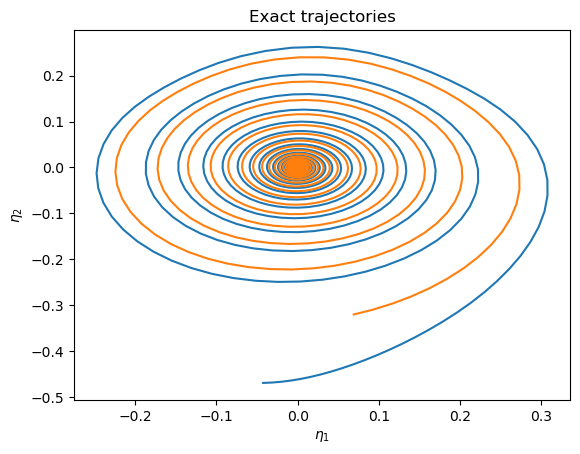

In [72]:
# Plot the trajectories in the normal form coordinates
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [73]:
trf

In [74]:
time_pred = np.linspace(0, 100, 1001)

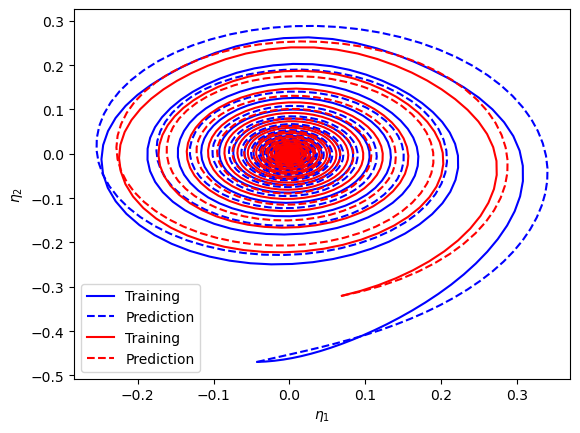

In [75]:
clit=1
for t in trajectories:
    if clit==1:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

Compare the results with order = 3, 5, 7, 9

Order: 3, Residual: 0.10415171298031752 

Order: 5, Residual: 0.00397551544422774 

Order: 7, Residual: 0.000537114295228391 

Order: 9, Residual: 0.00021898026345285718 



Text(0, 0.5, 'Relative error [%]')

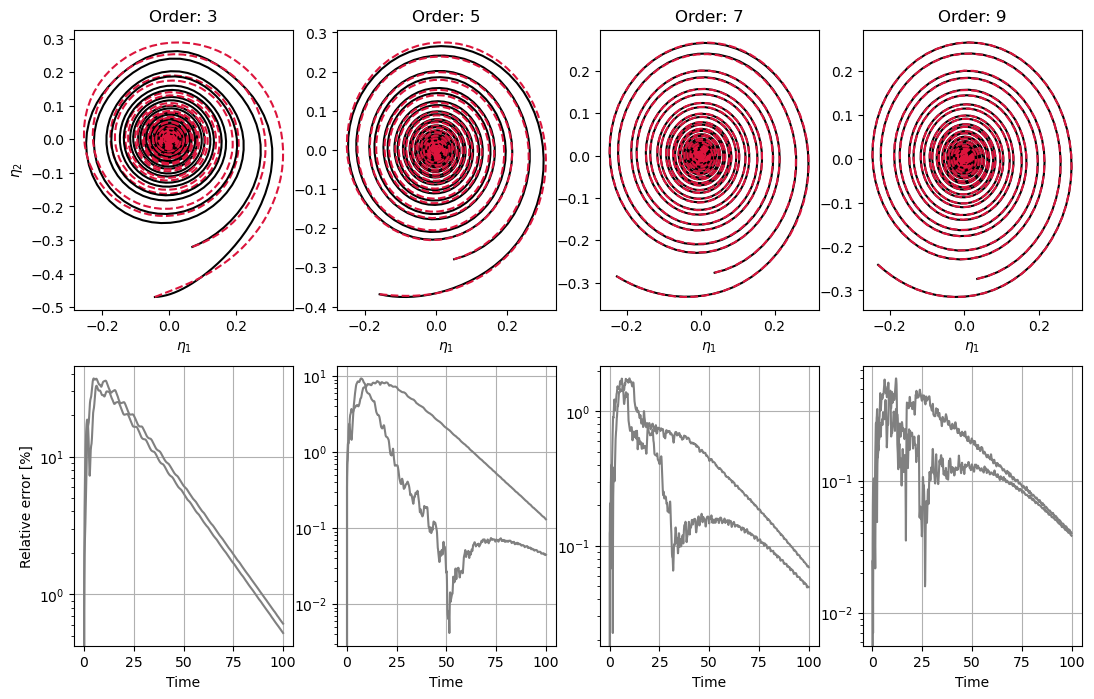

In [76]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')

### Predict different trajectories than the ones you trained with

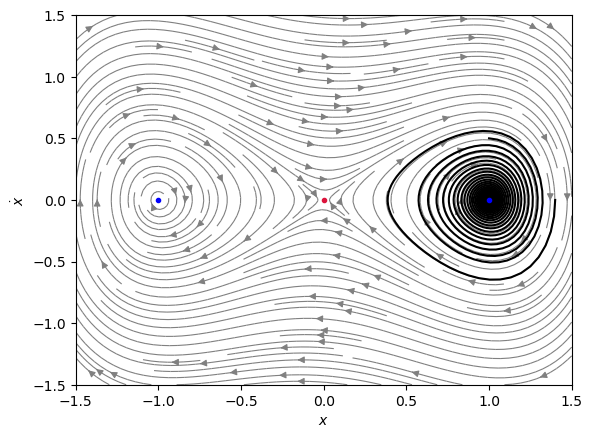

In [77]:
ic_2 = np.array([1.0, 0.5])
ic_3 = np.array([1.4, 0.])
t = np.linspace(0, 100, 1001)
sol_2 = solve_ivp(vectorfield, [t[0], t[-1]], ic_2, t_eval=t)
sol_3 = solve_ivp(vectorfield, [t[0], t[-1]], ic_3, t_eval=t)
trajectories_new = [sol_2.y - np.array([1,0]).reshape(-1,1), sol_3.y - np.array([1,0]).reshape(-1,1)]

xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories_new:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')

Text(0.5, 1.0, 'Exact trajectories')

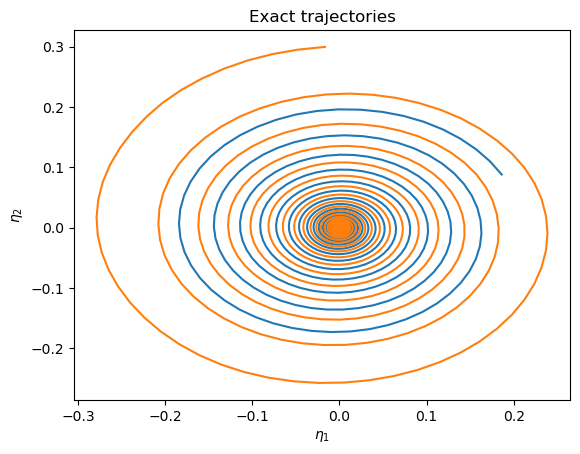

In [78]:
# Plot the trajectories in the normal form coordinates
for t in trajectories_new:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

Order: 3, Residual: 0.10415171298031752 

Order: 5, Residual: 0.00397551544422774 

Order: 7, Residual: 0.000537114295228391 

Order: 9, Residual: 0.00021898026345285718 



Text(0, 0.5, 'Relative error [%]')

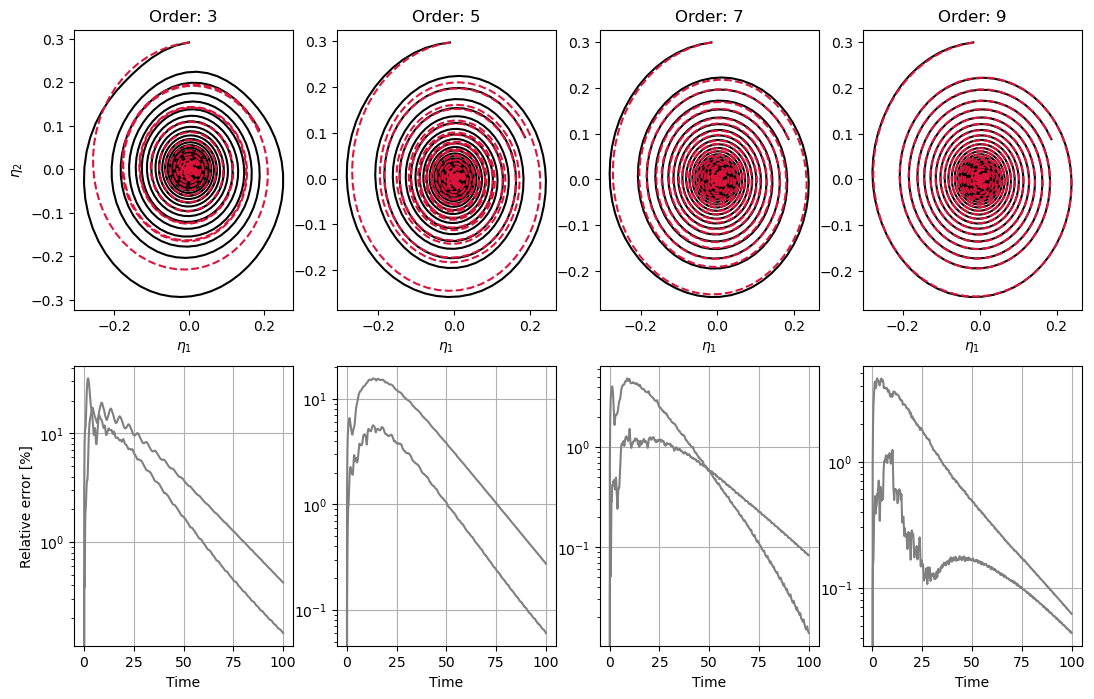

In [79]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories_new:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')

## Test on real data

In [80]:
from numpy import loadtxt

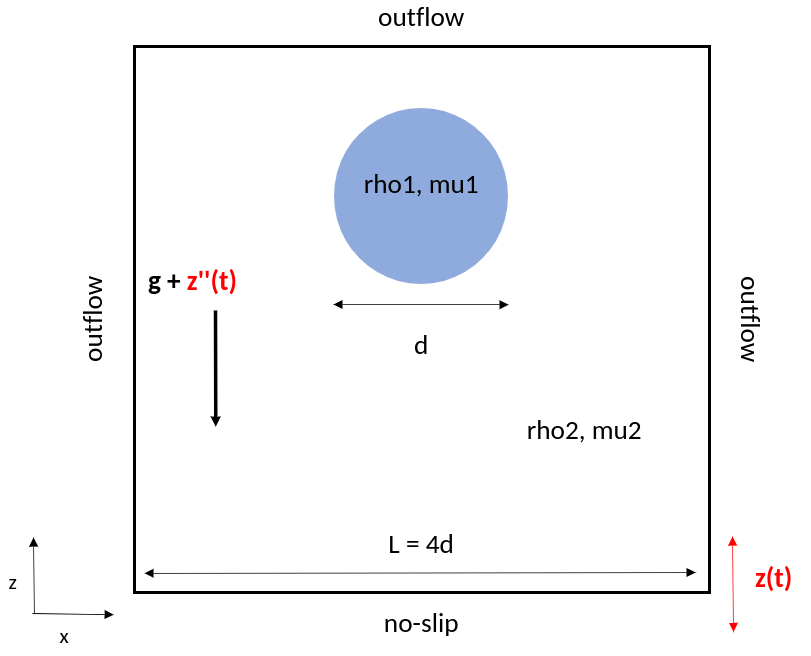

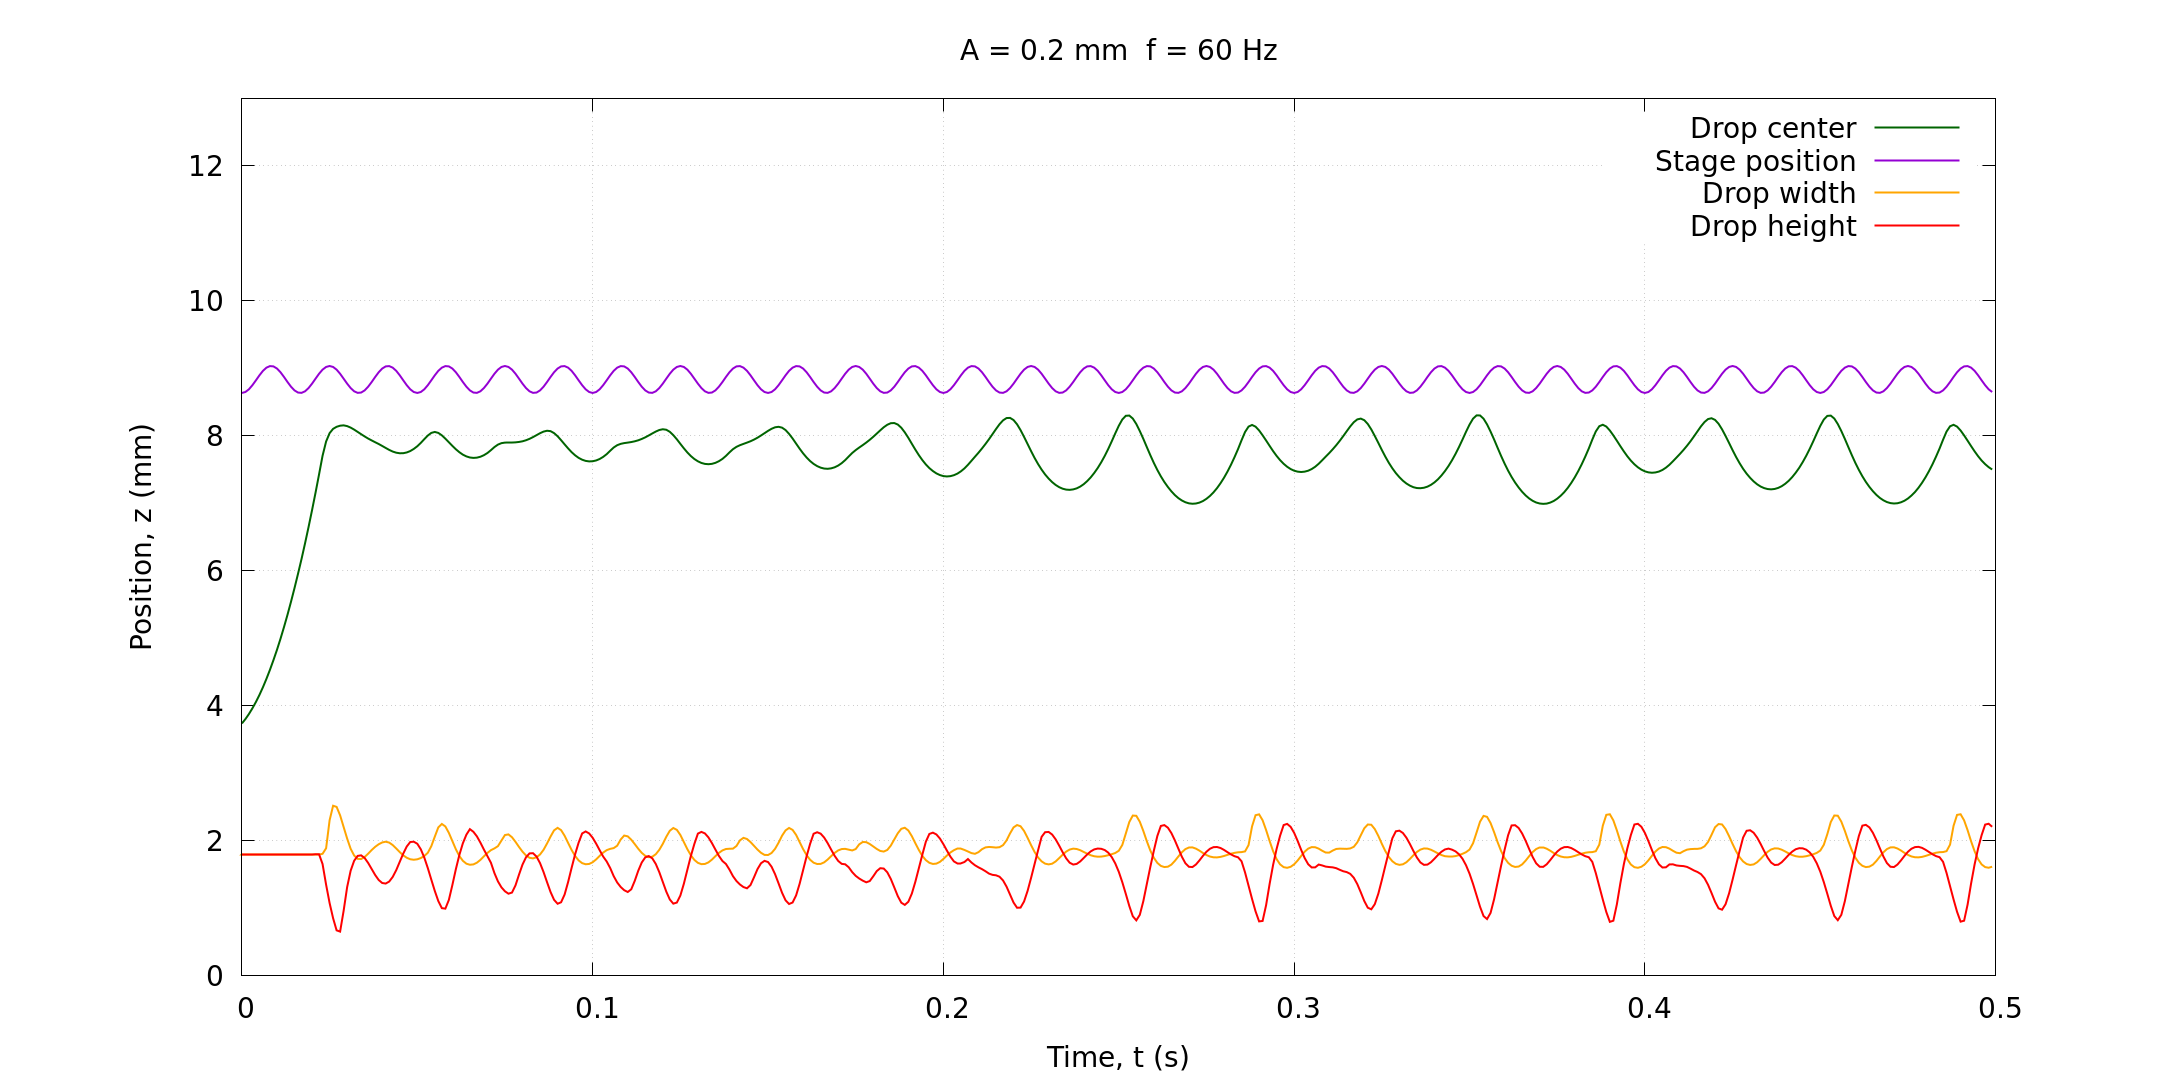

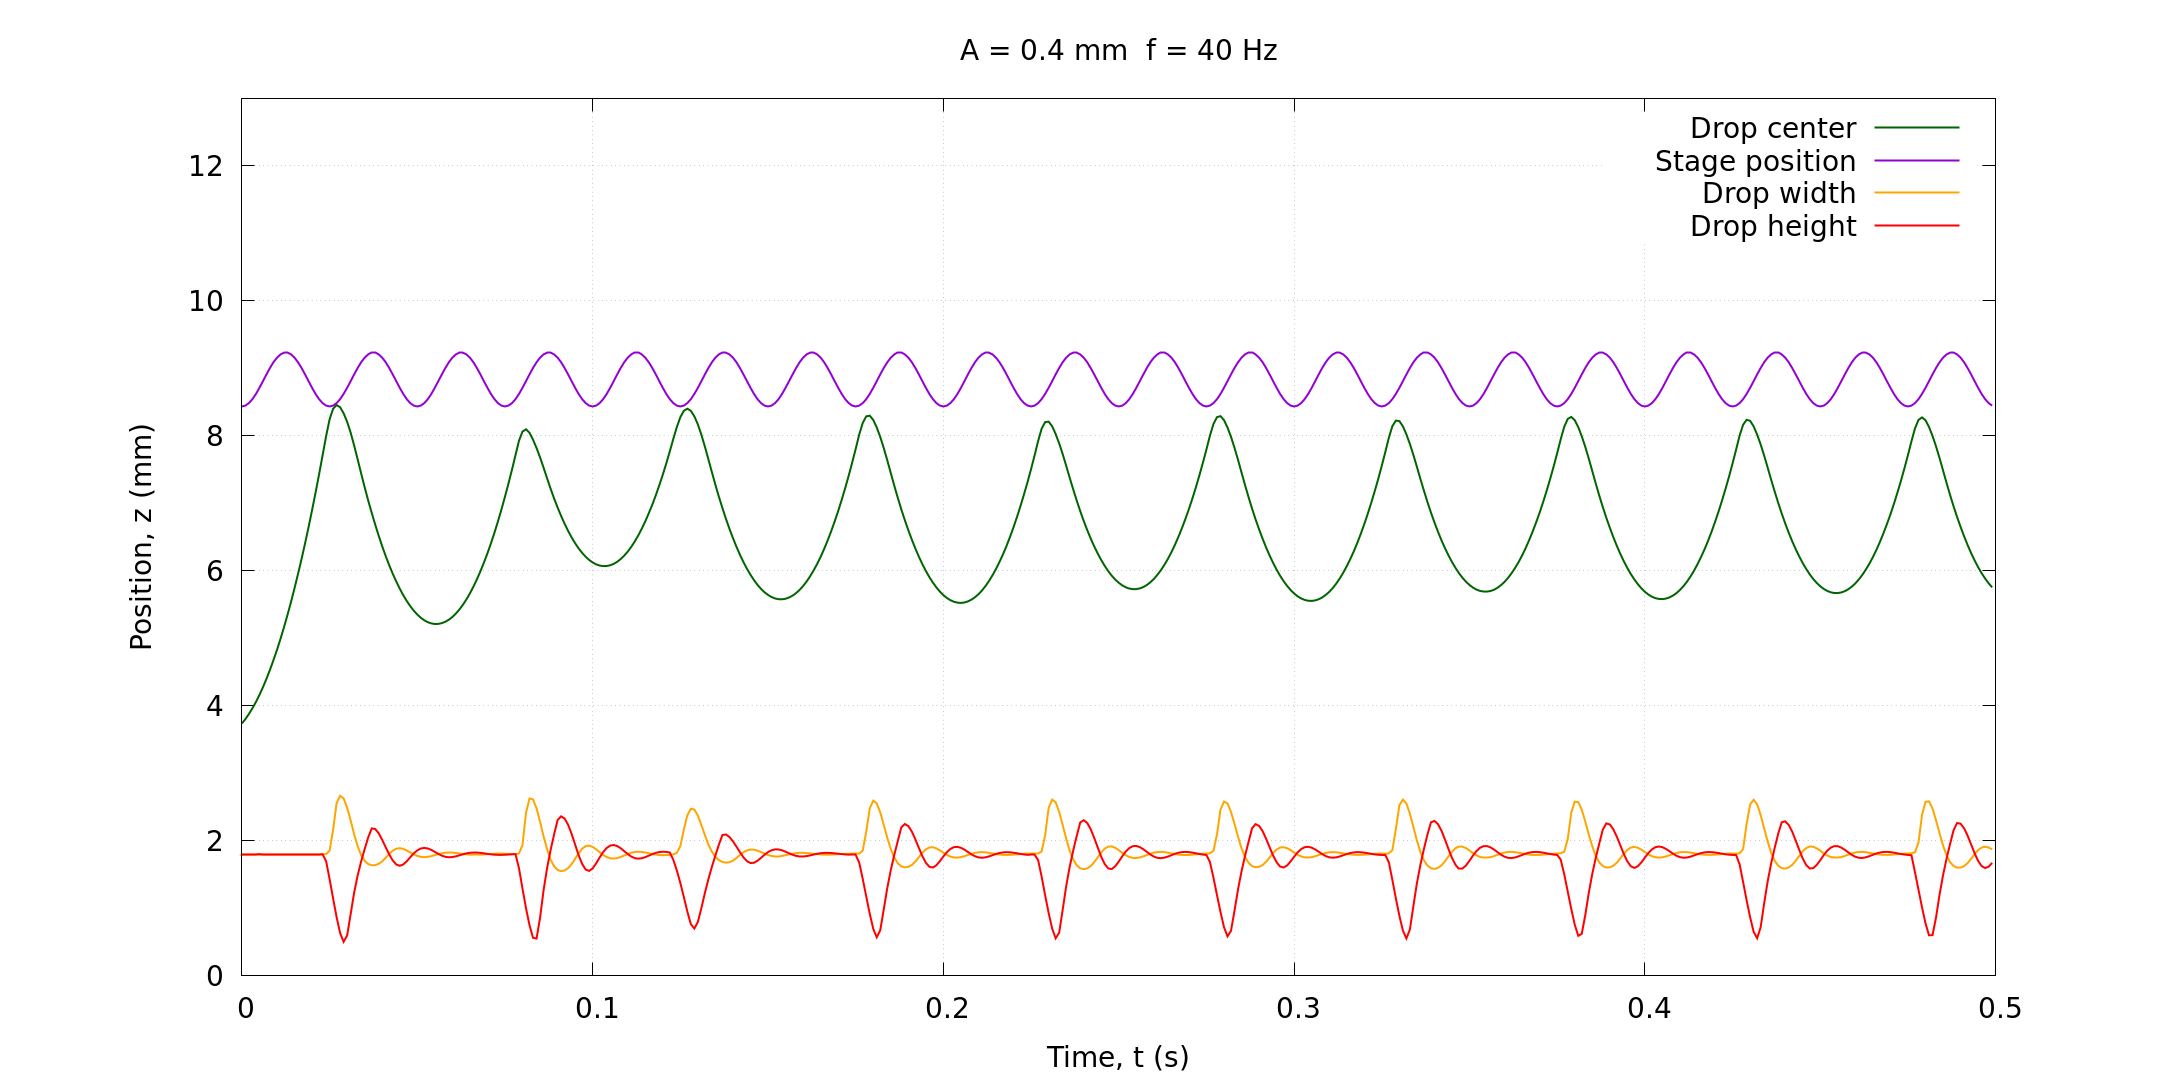

In [107]:
a1f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq2.00e+01_momentum0_LEVEL9")
a1f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq4.00e+01_momentum0_LEVEL9")
a1f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq6.00e+01_momentum0_LEVEL9")
a2f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq2.00e+01_momentum0_LEVEL9")
a2f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq4.00e+01_momentum0_LEVEL9")
a2f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq6.00e+01_momentum0_LEVEL9")
a3f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq2.00e+01_momentum0_LEVEL9")
a3f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq4.00e+01_momentum0_LEVEL9")
a3f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq6.00e+01_momentum0_LEVEL9")
a4f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq2.00e+01_momentum0_LEVEL9")
a4f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq4.00e+01_momentum0_LEVEL9")
a4f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq6.00e+01_momentum0_LEVEL9")

In [109]:
v_a1f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a1f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a1f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a2f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a2f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a2f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a3f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a3f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a3f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a4f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a4f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a4f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq6.00e+01_momentum0_LEVEL9")

In [197]:
a0f0 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp0.00e+00_freq0.00e+00_momentum0_LEVEL11")
v_a0f0 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp0.00e+00_freq0.00e+00_momentum0_LEVEL11")


In [258]:
l1 = 200
l2 = len(a1f2[:,0])

In [259]:
_trajectories = [ [a2f6[l1:l2, 2], v_a2f6[l1:l2, 3]] - np.array([1,0]).reshape(-1,1),\
                  [a3f4[l1:l2, 2], v_a2f4[l1:l2, 3]] - np.array([1,0]).reshape(-1,1) ]
_times = [a1f2[l1:l2,0], a1f2[l1:l2,0]]


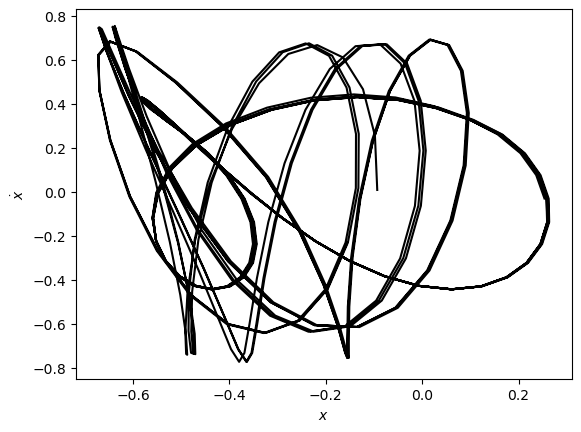

In [260]:
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')
for t in _trajectories:
    plt.plot(t[0,:], t[1,:], '-', c='black')

In [261]:
# Order
_polyDeg = 5
# Degrees of freedom
_ndofs = 1

_X, _y  = shift_or_differentiate(_trajectories, _times, 'flow') 

# constLHS = [[0, 1]]
# constRHS = [[0, 0]]
# cons = [constLHS, constRHS]

_mdl = ridge.get_fit_ridge(_X, _y, poly_degree = _polyDeg) #, constraints = cons)

_linearPart = _mdl.map_info['coefficients'][:,:2]

_nf, _n_unknowns_dynamics, _n_unknowns_transformation, _objectiv \
    = normalform.create_normalform_transform_objective(_times, _trajectories, _linearPart, degree = _polyDeg)

_initial_guess = normalform.create_normalform_initial_guess(_mdl, _nf)

np.random.seed(3)
_res = least_squares(_objectiv, _initial_guess, jac='2-point', method='lm')

_d = normalform.unpack_optimized_coeffs(_res.x, _ndofs, _nf, _n_unknowns_dynamics, _n_unknowns_transformation)

_trf, _dyn = normalform.wrap_optimized_coefficients(_ndofs, _nf, _polyDeg, _d )

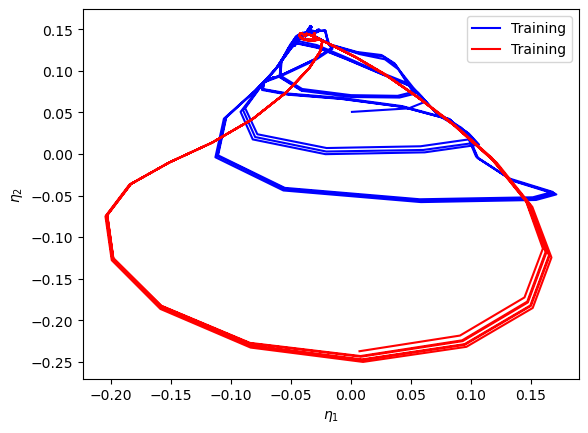

In [262]:
clit=1
for t in _trajectories:
    if clit==1:
        transformed = _trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        # pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        # plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = _trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        # pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        # plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

In [264]:
from ssmlearnpy import SSMLearn

ssm.predict(_times, _trajectories)

NameError: name 'ssm' is not defined